In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import shap
import seaborn as sns
import plotly.express as px
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import calendar
import requests
from sklearn.compose import ColumnTransformer

In [2]:
def read_file(file_path, year_from=2003):
    # Define the number of rows to skip
    num_rows_to_skip = 6
    # Read the Excel file, skipping the specified number of rows
    df = pd.read_excel(file_path, skiprows=num_rows_to_skip)
    
    df_temp = df[df["Disaster Type"]=="Extreme temperature "]
    df_heat = df_temp[df_temp['Disaster Subtype']=='Heat wave']
    
    df_heat_recent = df_heat[df_heat['Year']>=year_from]
    
    print("there are " + str(df_heat_recent.shape[0]) + " heatwave events")
    return df_heat_recent

In [3]:
# world
directory = '../data/raw/'
df_heat = read_file(directory + 'emdat_public_2023_08_18_query_uid-susUgT.xlsx')
df_heat.head()

Workbook contains no default style, apply openpyxl's default


there are 165 heatwave events


,Dis No,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,...,"Reconstruction Costs, Adjusted ('000 US$)",Insured Damages ('000 US$),"Insured Damages, Adjusted ('000 US$)",Total Damages ('000 US$),"Total Damages, Adjusted ('000 US$)",CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
59,2003-0391-AUT,2003,391,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,NaN,...,NaN,NaN,NaN,280000.0,445445.0,62.858460,1,478;479;480;481;482;483;484;485;486,NaN,"Burgenland, Karnten, Niederosterreich, Oberost..."
71,2003-0391-BEL,2003,391,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,62.858460,1,600;601;602,NaN,Region de Bruxelles-Capitale / Brussels Hoofds...
117,2004-0333-ALB,2004,333,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,64.541329,2,NaN,3819,Durres (Adm2).
195,2003-0391-CHE,2003,391,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,NaN,...,NaN,NaN,NaN,280000.0,445445.0,62.858460,1,2807;2808;2809;2810;2811;2812;2813;2814;2815;2...,NaN,"Aargau, Appenzell Ausser-rhoden, Appenzell Inn..."
196,2003-0391-DEU,2003,391,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,NaN,...,NaN,10000.0,15909.0,1650000.0,2624945.0,62.858460,1,1308;1309;1310;1311;1312;1313;1314;1315;1316;1...,NaN,"Baden-Wuerttemberg, Bayern, Berlin, Brandenbur..."


In [7]:
def countries_with_min_no_heatwaves(df_heat, threshold=3):
    select = df_heat.groupby('Country').count().reset_index().sort_values(by='Year', ascending=False)
    return len(select[select['Year']>=threshold])

top = countries_with_min_no_heatwaves(df_heat, threshold=3)
top

18

In [8]:
def heatwave_top_countries(df, top=None):
    df_sorted = df.groupby('Country').count().reset_index().sort_values(by='Year', ascending=False)
    
    if top == None:
        return_top = len(df_sorted) 
    else:
        return_top = top
    plt.barh(df_sorted.Country, df_sorted.Year, color=['red' if country in df_sorted.iloc[:return_top]['Country'].values else 'blue' for country in df_sorted.Country])
    plt.title('No. heatwaves per country')
    
    focus = list(df_sorted.iloc[:return_top]['Country'])
    top_country_data = df[df['Country'].isin(focus)] 
    print(top_country_data.shape)
    return top_country_data

(119, 50)


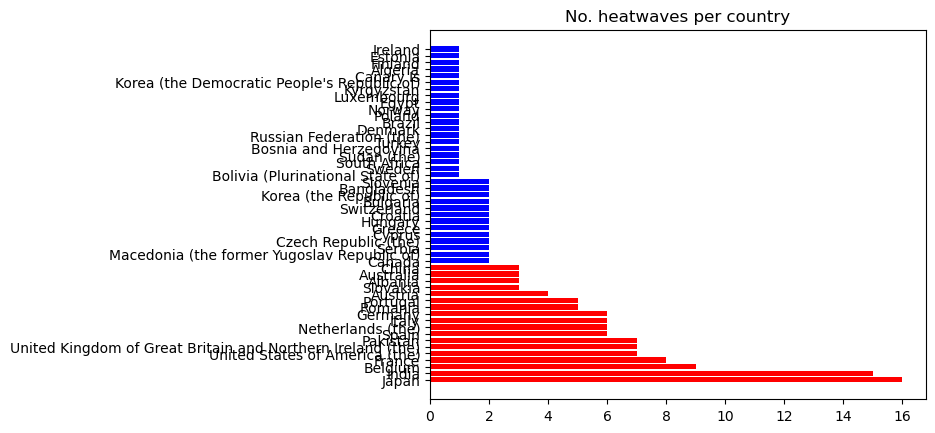

In [9]:
top_countries = heatwave_top_countries(df_heat, top)

In [10]:
def plot_deaths_overtime(df):
    '''
    Missing data are now considered and plotted as grey dots
    '''
    data = df.groupby('Year')["Total Deaths"].sum().reset_index()

    plt.figure(figsize=(10, 6))

    plt.plot(data['Year'], data['Total Deaths'], marker='o', linestyle='-', color='blue', label='Total Deaths')
    
    # Identify missing years and plot grey dots for them
    all_years = np.arange(data['Year'].min(), data['Year'].max() + 1)
    missing_years = np.setdiff1d(all_years, data['Year'])
    if len(missing_years) > 0:
        missing_data = np.zeros(len(missing_years))
        plt.scatter(missing_years, missing_data, color='grey', marker='o', label='Missing Years')

    plt.xlabel('Year')
    plt.ylabel('Total Deaths')
    plt.title('Line Chart with Deaths')
    
    # Set x-axis ticks to include all years
    plt.xticks(all_years)

    plt.legend()
    plt.show()

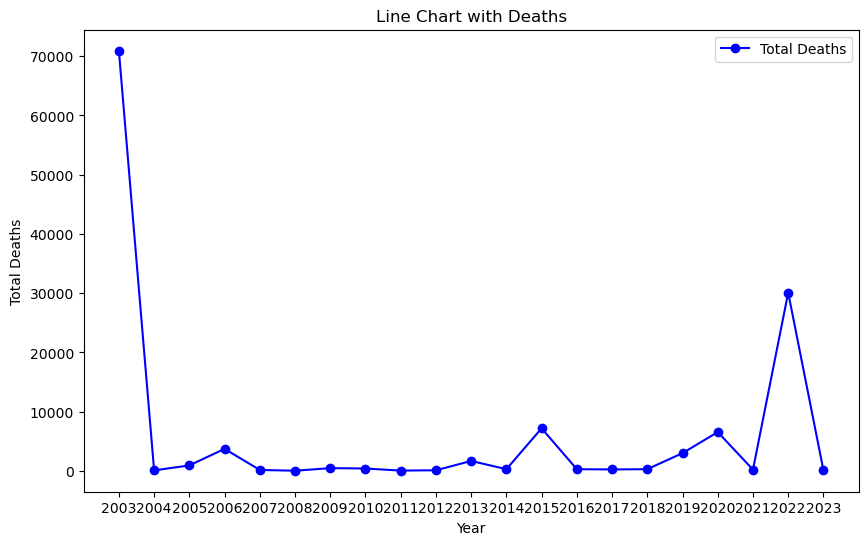

In [11]:
plot_deaths_overtime(top_countries)

# as we have better equipment to protect from disaster the number of death can be decreasing

In [2]:
top_countries_valid_death = top_countries[~top_countries['Total Deaths'].isna()]#.shape

NameError: name 'top_countries' is not defined

In [1]:
dfs = top_countries_valid_death.copy()
dfs.to_csv('../data/processed/country_focus.csv')

NameError: name 'top_countries_valid_death' is not defined

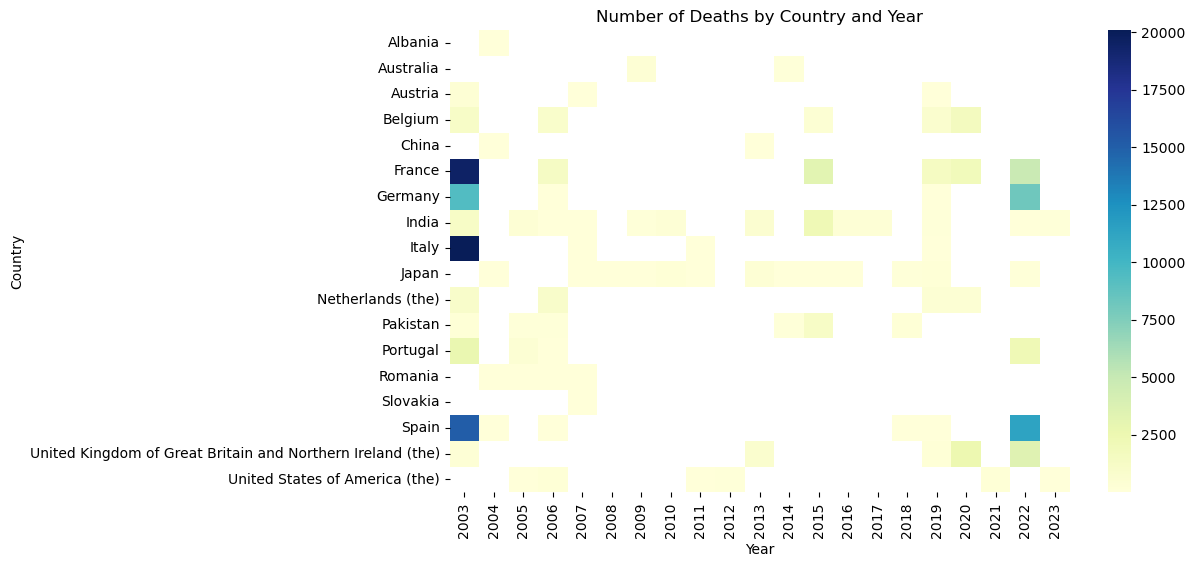

In [15]:
heatmap_data = dfs.pivot_table(index='Country', columns='Year', values='Total Deaths', aggfunc='sum')

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False)
plt.title('Number of Deaths by Country and Year')
plt.xlabel('Year')
plt.ylabel('Country')
plt.show()

In [18]:
def world_map(df, year):
    # Erstellung der Karte
    # Standorte = Alpha-3-Code für jedes Land
    
    df = df[df['Year']==year]
    print(df.shape)
    
    fig = px.choropleth(df, locations='ISO', color='Total Deaths',
                        color_continuous_scale='RdYlGn_r', template="plotly_dark",
                        title="Weltweiter Death Counts in " + str(year))
    
    # setzen der Mapbox
    # Stelle den Zoom ein, wenn das Diagramm angezeigt wird
    fig.update_layout(mapbox_style="carto-positron",
                      mapbox_zoom=10)
    # Titel
    fig.update_layout(title_x=0.5, margin={"r":0, "t":30,"l":0,"b":0})
    
    # Display the figure
    fig.show()

# Plot for particular year
world_map(dfs, 2003)

(11, 50)


In [19]:
def europe_map(df, year):
    fig = px.choropleth(df, locations='ISO', color='Total Deaths',
                        color_continuous_scale='RdYlGn_r', template="plotly_dark",
                        title="European Death Counts in " + str(year))

    # Define the boundary coordinates for Europe
    europe_boundary = {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [
                [
                    [-20, 35],
                    [40, 35],
                    [40, 70],
                    [-20, 70],
                    [-20, 35]
                ]
            ]
        }
    }

    # Add boundary shape to the map
    fig.add_shape(type="line",
                  x0=-20, y0=35, x1=40, y1=35,
                  line=dict(color="blue", width=2))

    fig.update_geos(
        fitbounds="locations",
        visible=False,  # Hide the world map
        showcoastlines=False,  # Hide coastlines
        projection_scale=1,  # Adjust scale if needed
        center={"lat": 52.0, "lon": 10.0},  # Adjust center as needed
        scope="europe",  # Set the map scope to Europe
    )

    fig.update_layout(title_x=0.5, margin={"r": 0, "t": 30, "l": 0, "b": 0})

    fig.show()

# Call the function
europe_map(dfs, 2003)